In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from pathlib import Path
import pandas as pd
import etta
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from astropy.time import Time

In [172]:
#Wobble results for TOI 4517_01

RESULTS_DIR = '/srv/scratch/astro/z5345592/results/tess_toi/4517_01'
RESULTS_PATH = Path(RESULTS_DIR) / '4517_01_wobble_rvs.txt'
RESULTS_TABLE = pd.read_csv(RESULTS_PATH, sep=' ', header=3)

In [173]:
TOI_INFO_TABLE = etta.download_toi('4517.01')

Fetching data from https://exofop.ipac.caltech.edu/tess/download_toi.php?output=pipe&toi=4517.01


In [174]:
#getting the useful information out of the tables.

dates = np.array(RESULTS_TABLE['dates'])
rvs_norm = np.array(RESULTS_TABLE['RV'] - np.median(RESULTS_TABLE['RV']))
rvs_err = np.array(RESULTS_TABLE['RV_err'])

x_ref = 0.5 * (dates.min() + dates.max()) # this is needed for some pymc3 stuff later
t = np.linspace(dates.min() - 5, dates.max() + 5, 50000)

toi_period = TOI_INFO_TABLE['Period (days)']
toi_period_err = TOI_INFO_TABLE['Period (days) err']
toi_epoch = TOI_INFO_TABLE['Epoch (BJD)']
toi_epoch_err = TOI_INFO_TABLE['Epoch (BJD) err']

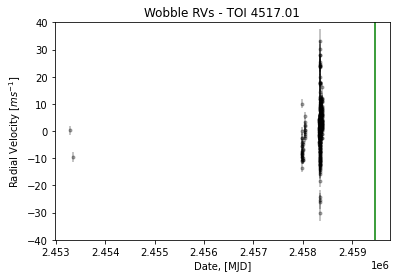

In [175]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.', alpha = 0.3)
plt.ylabel('Radial Velocity [$ms^{-1}$]')
plt.xlabel('Date, [MJD]')
plt.title('Wobble RVs - TOI 4517.01')
plt.ylim(-40,40)
plt.axvline(x=float(toi_epoch), c='g', label = 'TESS Transit')

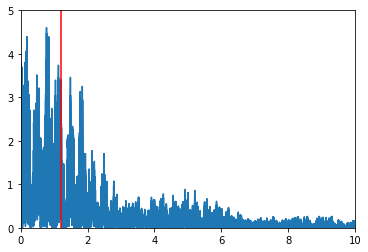

In [176]:
periodogram = xo.lomb_scargle_estimator(dates, rvs_norm, rvs_err, min_period=0.1)
plt.plot(periodogram['periodogram'][0], periodogram['periodogram'][1])
plt.xlim(0,10)
plt.ylim(0,5)
plt.axvline(x=float(toi_period), c='r')

In [10]:
#dates of observations:

dates_1 = [2457984, 2457994]
dates_2 = [2458045, 2458051]
dates_3 = [2458334.7, 2458334.96]
dates_4 = [2458345.6, 2458345.95]
dates_5 = [2458348.55, 2458348.9]
dates_6 = [2458379.5, 2458379.9]
dates_7 = [2458380.73, 2458380.88]

(-40.0, 40.0)

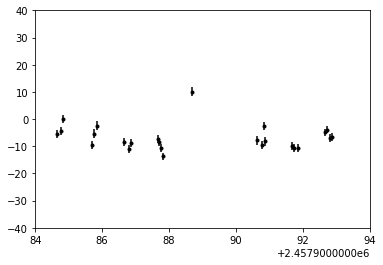

In [11]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_1)
plt.ylim(-40,40)

(-40.0, 40.0)

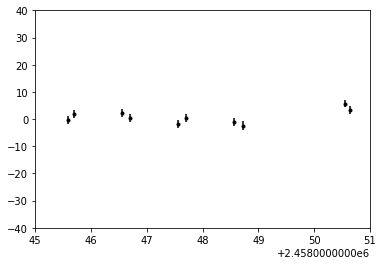

In [12]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_2)
plt.ylim(-40,40)

(-40.0, 40.0)

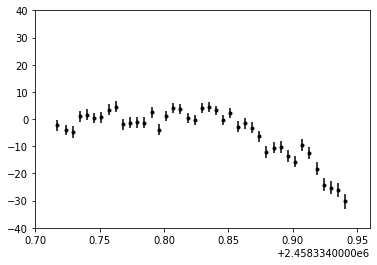

In [13]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_3)
plt.ylim(-40,40)

(-40.0, 40.0)

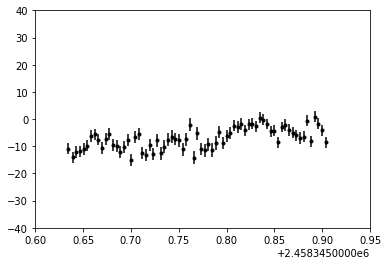

In [14]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_4)
plt.ylim(-40,40)

(-40.0, 40.0)

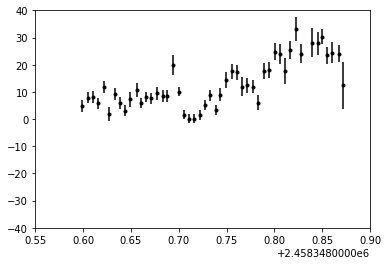

In [15]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_5)
plt.ylim(-40,40)

(-40.0, 40.0)

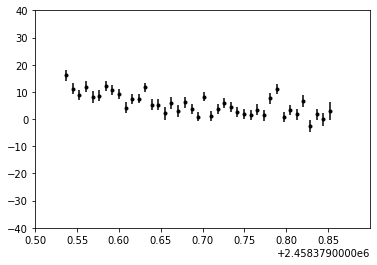

In [16]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_6)
plt.ylim(-40,40)

(-40.0, 40.0)

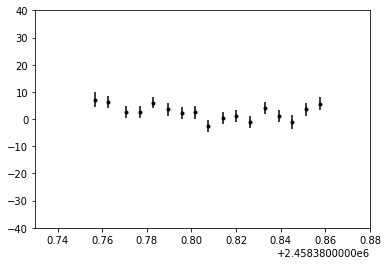

In [17]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt='k.')
plt.xlim(dates_7)
plt.ylim(-40,40)

In [18]:
Ks = xo.estimate_semi_amplitude(toi_period, dates, rvs_norm, yerr=rvs_err)

In [34]:
t0s = toi_epoch
t0_errs = toi_epoch_err
periods = toi_period
period_errs = toi_period_err
num_planets = 1
yerr = rvs_err
x = dates
y = rvs_norm

with pm.Model() as model:

    # Gaussian priors
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(3*t0_errs), shape=num_planets)
    # t0 = pm.Uniform("t0", lower = float(toi_epoch - toi_epoch_err), upper = float(toi_epoch + toi_epoch_err))
    logP = pm.Normal("logP", mu=np.log(periods), sd=np.array(period_errs) / np.array(periods), shape=num_planets, testval=np.log(periods))
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=2.0, shape=num_planets, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, num_planets), testval=0.01 * np.ones((2, num_planets)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=num_planets, fixed=True, observed=ecc)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(2)[:-1], shape=2)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):

        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 2)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


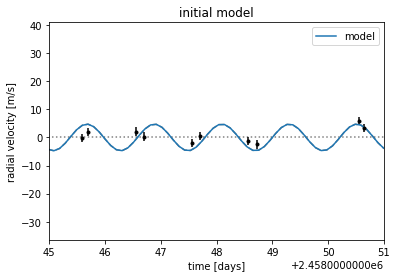

In [35]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(dates_2)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [37]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -1800.558444336502 -> -1789.1897688688266
optimizing logp for variables: [logs, logP, logK, trend, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -1789.1897688688266 -> -978.7895583482931
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -978.7895583482931 -> -977.9636206142553
optimizing logp for variables: [trend, logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -977.9636206142553 -> -977.6336837080104


NameError: name 'map_soln' is not defined

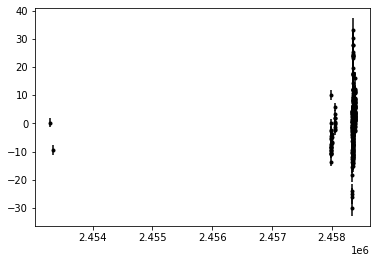

In [133]:
plt.errorbar(dates, rvs_norm, yerr=rvs_err, fmt=".k")
# plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
# plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
# plt.xlim(dates_2)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model")

In [46]:
new_rvs = rvs_norm - map_soln['rv_model']

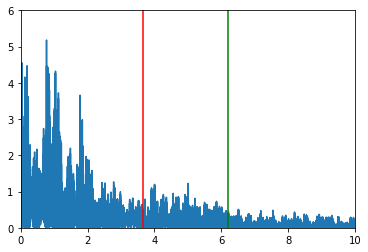

In [59]:
periodogram = xo.lomb_scargle_estimator(dates, new_rvs, rvs_err, min_period=0.1, max_peaks=4)
plt.plot(periodogram['periodogram'][0], periodogram['periodogram'][1])
plt.xlim(0,10)
plt.ylim(0,6)
plt.axvline(x=3.6480957, c='r')
plt.axvline(x=6.2014698, c='g')

In [68]:
TOI_INFO_TABLE.loc[4517.01]['Period (days)']

1.20891224083645

In [69]:
import pandas as pd

In [19]:
mcmc_results = pd.read_csv('sample_summary.csv')

,Unnamed: 0,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,trend[0],0.002,0.000,0.001,0.003,0.000,0.000,2109.0,1528.0,1.0
1,trend[1],-0.631,0.907,-2.248,1.092,0.019,0.017,2305.0,1637.0,1.0
2,logs,2.026,0.051,1.930,2.121,0.001,0.001,1595.0,1310.0,1.0
3,omega[0],0.325,1.043,-1.874,2.575,0.027,0.025,1416.0,1339.0,1.0
4,ecc[0],0.104,0.097,0.000,0.297,0.005,0.004,478.0,1062.0,1.0
5,t0[0],2459448.315,0.005,2459448.307,2459448.325,0.000,0.000,2217.0,1389.0,1.0
6,logK[0],2.196,0.144,1.917,2.469,0.006,0.004,719.0,1141.0,1.0
7,P[0],1.209,0.000,1.209,1.209,0.000,0.000,615.0,766.0,1.0


In [141]:
gradient = mcmc_results.iloc[0]['mean']
intercept = mcmc_results.iloc[1]['mean']
intercept_err = mcmc_results.iloc[1]['sd']

In [1]:
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

ModuleNotFoundError: No module named 'eleanor'